# Data Quality project on data imputation

## Dataset import and null values injection procedure

In [53]:
import pandas as pd
import dirty_completeness
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# Original dataset inspection

original_data = pd.read_csv("car.csv")
original_data

,index,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [55]:
original_data.dtypes

index       object
buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

In [56]:
cols = original_data.columns

unique_values = []

for col in cols:
    unique_values.append(dict({col: original_data[col].unique()}))

unique_values

[{'index': array(['vhigh', 'high', 'med', 'low'], dtype=object)},
 {'buying': array(['vhigh', 'high', 'med', 'low'], dtype=object)},
 {'maint': array(['2', '3', '4', '5more'], dtype=object)},
 {'doors': array(['2', '4', 'more'], dtype=object)},
 {'persons': array(['small', 'med', 'big'], dtype=object)},
 {'lug_boot': array(['low', 'med', 'high'], dtype=object)},
 {'safety': array(['unacc', 'acc', 'vgood', 'good'], dtype=object)}]

In [57]:
counts = []

for i in range(len(cols)):
    counts.append(original_data[cols[i]].value_counts())

counts

[vhigh    432
 high     432
 med      432
 low      432
 Name: index, dtype: int64,
 vhigh    432
 high     432
 med      432
 low      432
 Name: buying, dtype: int64,
 2        432
 3        432
 4        432
 5more    432
 Name: maint, dtype: int64,
 2       576
 4       576
 more    576
 Name: doors, dtype: int64,
 small    576
 med      576
 big      576
 Name: persons, dtype: int64,
 low     576
 med     576
 high    576
 Name: lug_boot, dtype: int64,
 unacc    1210
 acc       384
 good       69
 vgood      65
 Name: safety, dtype: int64]

c:\Users\matte\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '384 (22.22%)'),
 Text(0, 0, '69 (3.99%)'),
 Text(0, 0, '1210 (70.02%)'),
 Text(0, 0, '65 (3.76%)')]

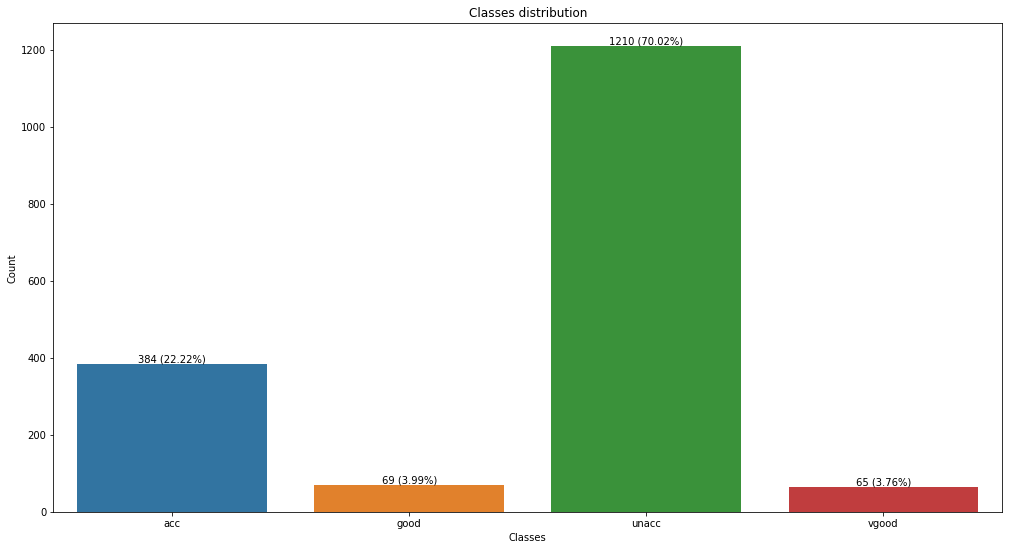

In [58]:
# Plot the number of rows for each class in the target column

target_column = np.sort(original_data[original_data.columns[-1]].to_numpy())
plt.figure(figsize=(17,9))
ax = sns.countplot(target_column)
        
d, abs_values = np.unique(target_column, return_counts=True)
rel_values = abs_values/abs_values.sum() * 100
lbls = [f'{p[0]} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.set_xlabel("Classes")
ax.set_ylabel("Count")
ax.set_title("Classes distribution")
ax.bar_label(container=ax.containers[0], labels=lbls)

In [59]:
# Errors injection

seed = 1234     # random seed for reproducibility
name = "car"    # name of the dataset

original_data = pd.read_csv("car.csv")

targeted_class = original_data.columns[-1]    # Target class is the last attribute
targeted_class

data_list = dirty_completeness.injection(original_data, seed=seed, name=name, name_class=targeted_class)

saved car-completeness50%
saved car-completeness60%
saved car-completeness70%
saved car-completeness80%
saved car-completeness90%


In [60]:
targeted_class

'safety'

Use the first dataset for some checks

In [61]:
data = data_list[0]
data.head()

,index,buying,maint,doors,persons,lug_boot,safety
0,NaN,NaN,NaN,NaN,NaN,low,unacc
1,vhigh,vhigh,NaN,NaN,NaN,NaN,unacc
2,NaN,vhigh,2,NaN,small,high,unacc
3,vhigh,NaN,NaN,2,med,NaN,unacc
4,vhigh,vhigh,2,2,NaN,NaN,unacc


In [62]:
#check if targeted class was modified
data[targeted_class].isnull().sum() 

0

In [63]:
#create a copy dataset without the targeted class
ft_data = data.drop(targeted_class, axis=1)
ft_data.head()

,index,buying,maint,doors,persons,lug_boot
0,NaN,NaN,NaN,NaN,NaN,low
1,vhigh,vhigh,NaN,NaN,NaN,NaN
2,NaN,vhigh,2,NaN,small,high
3,vhigh,NaN,NaN,2,med,NaN
4,vhigh,vhigh,2,2,NaN,NaN


In [64]:
#display the number of null values for each column
ft_data.isnull().sum()

index       861
buying      827
maint       878
doors       848
persons     865
lug_boot    861
dtype: int64

## Imputation methods

In [65]:
def evaluate_completeness(data):
    """function that evaluates the completeness of a given dataset"""

    missing_columns = data.columns[:-1]
    #total number of null values
    null_values = data[missing_columns].isnull().sum().sum()

    #total number of cells without targeted column
    n_values = data.shape[0]*data[missing_columns].shape[1]

    #COMPLETENESS evaluation
    completeness = (n_values - null_values) / n_values
    
    return completeness


In [66]:
def accuracy_assessment(imputed_data):
    '''function to assess the accuracy of the imputed data with respect to the original data'''
    correct_values = []
    accuracies = []
    n_rows = imputed_data.shape[0]
    n_values = imputed_data.shape[0] * imputed_data.shape[1]
    columns = imputed_data.columns

    for col in columns:
        n_wrong = imputed_data[col].compare(original_data[col]).shape[0]
        accuracy = (n_rows-n_wrong)/n_rows
        correct_values.append(n_rows-n_wrong)
        accuracies.append([col, '{0:.2f} %'.format(accuracy*100)])


    global_accuracy = np.array(correct_values).sum() / n_values
    
    return global_accuracy, accuracies

### First imputation tecnique: Mode (standard tecnique)

In [67]:
def mode_imputation(data):
    """Function that applies the mode as tecnique to impute missing values"""

    missing_columns = data.columns

    imputed_data = data.copy()

    for col in missing_columns:
        imputed_data[col] = imputed_data[col].fillna(imputed_data[col].mode()[0])

    return imputed_data

### Second imputation tecnique: Matrix Factorization (advanced)

In [68]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

def integer_decode(df, variable, mappin):
    inv_map = {v: k for k, v in mappin[variable].items()}
    df[variable] = df[variable].map(inv_map)

def mf_imputation(data):
    from fancyimpute import MatrixFactorization

    missing_columns = data.columns

    imputed_data = data.copy()

    df = data.copy()

    #Mapping definition
    mappin = dict()
    for col in missing_columns:
        mappings = find_category_mappings(df, col)
        mappin[col] = mappings

    #Apply mapping
    for col in missing_columns:
        integer_encode(df, col, mappin[col])  

    mf_imputer = MatrixFactorization() 
    df_mf = pd.DataFrame(mf_imputer.fit_transform(df))
    df_mf.columns = df.columns

    for col in df_mf.columns: 
        df_mf[col] = round(df_mf[col]).astype('int')

    #Inverse transform
    for col in missing_columns:
        integer_decode(df_mf, col, mappin)

    for col in missing_columns:
        imputed_data[col] = df_mf[col]

    return imputed_data

## Machine Learning algorithms implementation

In [69]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [70]:
def dataset_preparation(data, feature_cols, target_col, train_split):
    """Function that recives a dataframe, encodes the labels of the targeted class and splits the data into train set and test set"""
    
    df = data.copy()

    #mapping definition
    mappin = dict()

    mappings = find_category_mappings(df, target_col)
    mappin[target_col] = mappings

    #apply mapping to target column
    integer_encode(df, target_col, mappin[target_col])  
    
    X = pd.get_dummies(df[feature_cols]) # the original features are converted to One Hot Encoding format
    y = df[target_col] # target variable

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_split, random_state=seed)

    return X_train, X_test, y_train, y_test

In [71]:
def evaluate_results(y, y_pred):
    """Function that evaluates the results of a classification algorithm. It computes accuracy, precision, recall, f1 score and the confusion matrix"""

    #compute the confusion matrix
    cm = confusion_matrix(y, y_pred)

    #compute the classification metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')

    return cm, accuracy, precision, recall, f1

### First Machine Learning tecnique: Decision Tree

In [72]:
from sklearn.tree import DecisionTreeClassifier 

def decision_tree_classification(imputed_data):
    """Function that splits the dataset in train and test set, applies a decision tree classifier and evaluates the results"""

    feature_columns = imputed_data.columns[:-1]
    targeted_class = imputed_data.columns[-1]

    X_train, X_test, y_train, y_test = dataset_preparation(imputed_data, feature_columns, targeted_class, 0.2)
    
    #create Decision Tree classifer object
    clf = DecisionTreeClassifier()

    #train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #predict the response for test dataset
    y_pred = clf.predict(X_test)

    cm, accuracy, precision, recall, f1 = evaluate_results(y_test, y_pred)
    return cm, accuracy, precision, recall, f1

### Second Machine Learning tecnique: Logistic regression

In [73]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_classification(imputed_data):
    """Function that splits the dataset in train and test set, applies a decision tree classifier and evaluates the results"""

    feature_columns = imputed_data.columns[:-1]
    targeted_class = imputed_data.columns[-1]
    
    X_train, X_test, y_train, y_test = dataset_preparation(imputed_data, feature_columns, targeted_class, 0.2)
    
    #create Logistic Regression classifer object
    clf = LogisticRegression(multi_class='ovr', solver='liblinear') # use One Vs Rest algorithm due to multiclass problem

    #train Logistic Regression Classifer
    clf = clf.fit(X_train,y_train)

    #predict the response for test dataset
    y_pred = clf.predict(X_test)

    cm, accuracy, precision, recall, f1 = evaluate_results(y_test, y_pred)
    return cm, accuracy, precision, recall, f1

## Main Loop

In [74]:
#Results lists

#accuracies after imputation
accuracies_standard_imputation = []
accuracies_advanced_imputation = []

#results of decision tree (dt) algorithm
dt_standard_imputation = []
dt_advanced_imputation = []

#results of logistic regression (lr) algorithm
lr_standard_imputation = []
lr_advanced_imputation = []

In [75]:
# Main loop
completeness_scores = []

for i in range(len(data_list)):

    data = data_list[i]
    missing_columns = data.columns[:-1]
    target_column = data.columns[-1]

    completeness_scores.append(evaluate_completeness(data))
    
    data_standard_imputation = mode_imputation(data[missing_columns].copy())
    accuracies_standard_imputation.append(accuracy_assessment(data_standard_imputation))
    data_standard_imputation['safety'] = data[target_column]

    data_advanced_imputation = mf_imputation(data[missing_columns].copy())
    accuracies_advanced_imputation.append(accuracy_assessment(data_advanced_imputation))
    data_advanced_imputation['safety'] = data[target_column]

    #apply decision tree classification to the dataset imputed with the mode tecnique
    temp_results = list(decision_tree_classification(data_standard_imputation))
    dt_standard_imputation.append(temp_results)

    #apply decision tree classification to the dataset imputed with the matrix factorization tecnique
    temp_results = list(decision_tree_classification(data_advanced_imputation))
    dt_advanced_imputation.append(temp_results)

    #apply logistic regression classification to the dataset imputed with the mode tecnique
    temp_results = list(logistic_regression_classification(data_standard_imputation))
    lr_standard_imputation.append(temp_results)

    #apply logistic regression classification to the dataset imputed with the matrix factorization tecnique
    temp_results = list(logistic_regression_classification(data_advanced_imputation))
    lr_advanced_imputation.append(temp_results)

[MatrixFactorization] Iter 10: observed MAE=0.695985 rank=40
[MatrixFactorization] Iter 20: observed MAE=0.058355 rank=40
[MatrixFactorization] Iter 30: observed MAE=0.003607 rank=40
[MatrixFactorization] Iter 40: observed MAE=0.000393 rank=40
[MatrixFactorization] Iter 50: observed MAE=0.000053 rank=40


c:\Users\matte\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matte\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[MatrixFactorization] Iter 10: observed MAE=0.634989 rank=40
[MatrixFactorization] Iter 20: observed MAE=0.026974 rank=40
[MatrixFactorization] Iter 30: observed MAE=0.001244 rank=40
[MatrixFactorization] Iter 40: observed MAE=0.000097 rank=40
[MatrixFactorization] Iter 50: observed MAE=0.000009 rank=40


c:\Users\matte\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[MatrixFactorization] Iter 10: observed MAE=0.576132 rank=40
[MatrixFactorization] Iter 20: observed MAE=0.026399 rank=40
[MatrixFactorization] Iter 30: observed MAE=0.001601 rank=40
[MatrixFactorization] Iter 40: observed MAE=0.000152 rank=40
[MatrixFactorization] Iter 50: observed MAE=0.000017 rank=40


c:\Users\matte\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[MatrixFactorization] Iter 10: observed MAE=0.505291 rank=40
[MatrixFactorization] Iter 20: observed MAE=0.016962 rank=40
[MatrixFactorization] Iter 30: observed MAE=0.000923 rank=40
[MatrixFactorization] Iter 40: observed MAE=0.000082 rank=40
[MatrixFactorization] Iter 50: observed MAE=0.000008 rank=40
[MatrixFactorization] Iter 10: observed MAE=0.453580 rank=40
[MatrixFactorization] Iter 20: observed MAE=0.014781 rank=40
[MatrixFactorization] Iter 30: observed MAE=0.000698 rank=40
[MatrixFactorization] Iter 40: observed MAE=0.000054 rank=40
[MatrixFactorization] Iter 50: observed MAE=0.000004 rank=40


# Results plots

In [76]:
nan_percentages = ["0.5", "0.6", "0.7", "0.8", "0.9"]

def plot_results_bar(standard_values, advanced_values, title, ylabel):
    
    print(standard_values)
    print(advanced_values)

    """
    Function that plots a bar graph comparing values in input from the standard imputation and the advanced imputation methods with respect to
    dirent percentages of injected missing values
    """
    x_axis = np.arange(len(nan_percentages))
    
    plt.figure(figsize=(10, 8))
    plt.bar(x_axis-0.22, standard_values, width=0.4, label='Standard method (mode)')
    plt.bar(x_axis+0.22, advanced_values, width=0.4, label='Advanced method (Matrix Factorization)')

    plt.xticks(x_axis, nan_percentages)
    plt.legend()
    plt.title(title)
    plt.xlabel("Percentage of injected missing values")
    plt.ylabel(ylabel)

### Imputed datasets accuracies

[0.6428433641975309, 0.7104552469135802, 0.7842399691358025, 0.8505979938271605, 0.9291087962962963]
[0.6487268518518519, 0.7167245370370371, 0.7887731481481481, 0.8542631172839507, 0.9311342592592593]


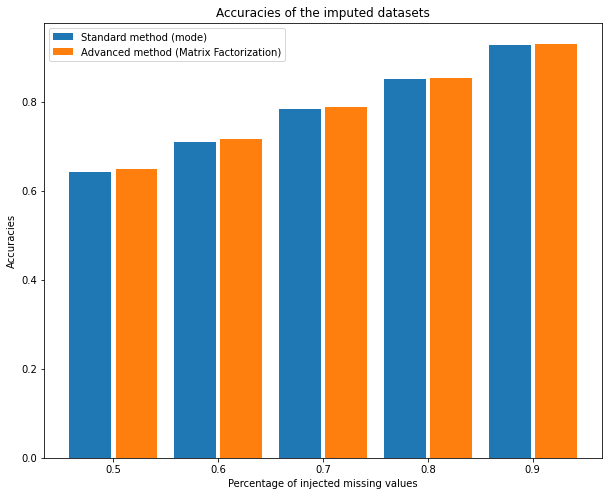

In [77]:
values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(accuracies_standard_imputation[i][0])
    values_advanced.append(accuracies_advanced_imputation[i][0])

plot_results_bar(values_standard, values_advanced, 
                "Accuracies of the imputed datasets", "Accuracies")

### Machine Learning algorithms accuracies

[0.6820809248554913, 0.6676300578034682, 0.7427745664739884, 0.7572254335260116, 0.8121387283236994]
[0.6416184971098265, 0.6705202312138728, 0.7312138728323699, 0.7745664739884393, 0.8179190751445087]


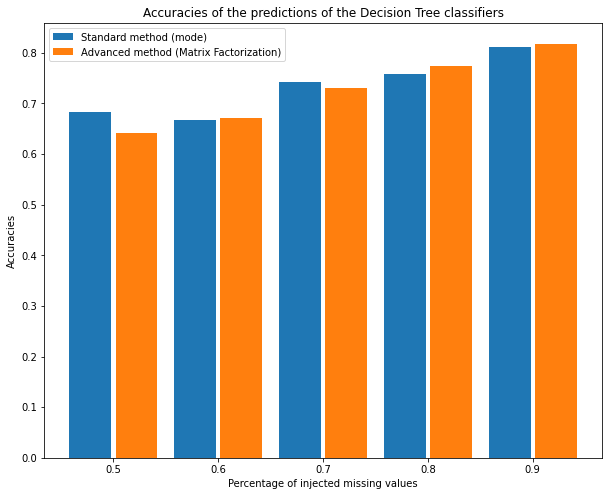

In [78]:
#decision tree

values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(dt_standard_imputation[i][1])
    values_advanced.append(dt_advanced_imputation[i][1])

plot_results_bar(values_standard, values_advanced, 
                "Accuracies of the predictions of the Decision Tree classifiers", "Accuracies")

[0.7167630057803468, 0.7109826589595376, 0.7543352601156069, 0.7716763005780347, 0.8092485549132948]
[0.6820809248554913, 0.7196531791907514, 0.7803468208092486, 0.7803468208092486, 0.815028901734104]


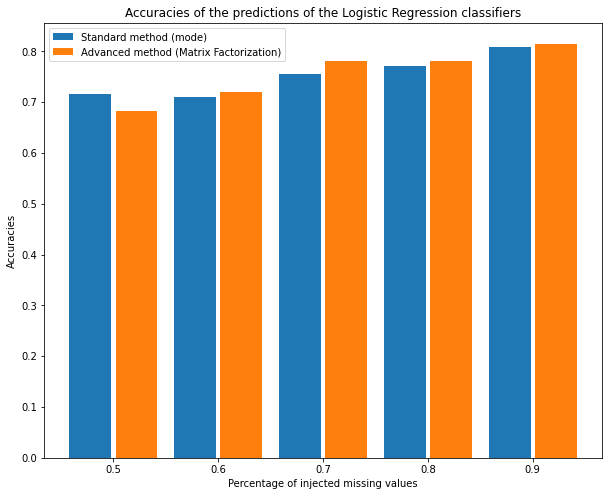

In [79]:
#logistic regression

values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(lr_standard_imputation[i][1])
    values_advanced.append(lr_advanced_imputation[i][1])

plot_results_bar(values_standard, values_advanced, 
                "Accuracies of the predictions of the Logistic Regression classifiers", "Accuracies")

### Machine Learning algorithms precisions

[0.41644154725550075, 0.38953864487572354, 0.4377391886720245, 0.5495588756458322, 0.6153964102751797]
[0.30354188821930755, 0.29473579855259247, 0.5076200782698718, 0.6564393939393939, 0.6459724486040276]


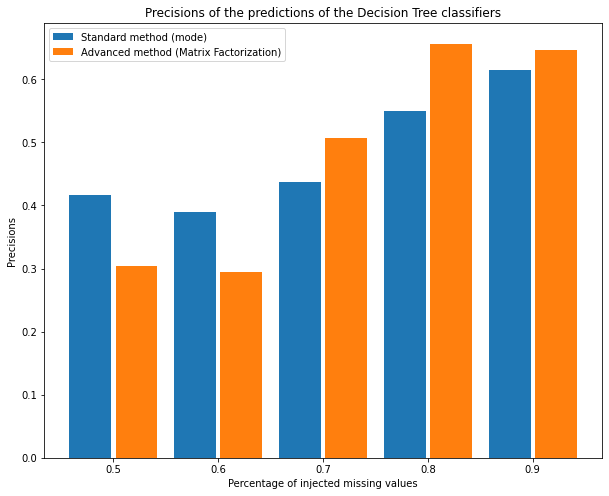

In [80]:
#decision tree

values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(dt_standard_imputation[i][2])
    values_advanced.append(dt_advanced_imputation[i][2])

plot_results_bar(values_standard, values_advanced, 
                "Precisions of the predictions of the Decision Tree classifiers", "Precisions")

[0.34735202492211836, 0.5548469387755102, 0.3416203937405351, 0.49446232283440295, 0.7476607374467297]
[0.39244479495268136, 0.3787878787878788, 0.6012922903333862, 0.49669940853400935, 0.7764025725232622]


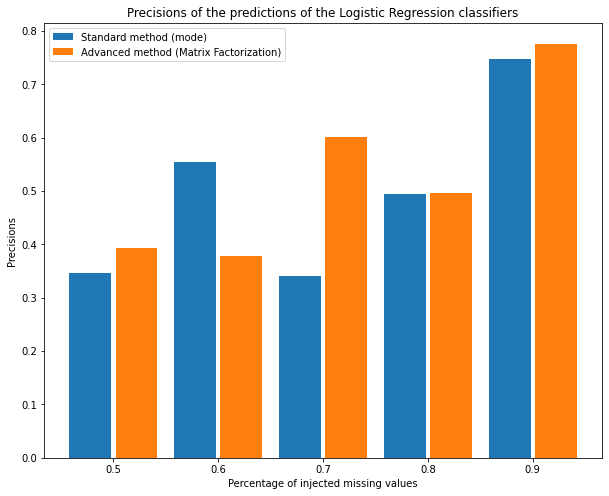

In [81]:
#logistic regression

values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(lr_standard_imputation[i][2])
    values_advanced.append(lr_advanced_imputation[i][2])

plot_results_bar(values_standard, values_advanced, 
                "Precisions of the predictions of the Logistic Regression classifiers", "Precisions")

### Machine Learning algorithms recalls

[0.3203200429107813, 0.3755110554860242, 0.38803712974551524, 0.4851525716669646, 0.5793722808272245]
[0.2923878061863043, 0.306883604505632, 0.4669698730556052, 0.5817748375946122, 0.6020479468383098]


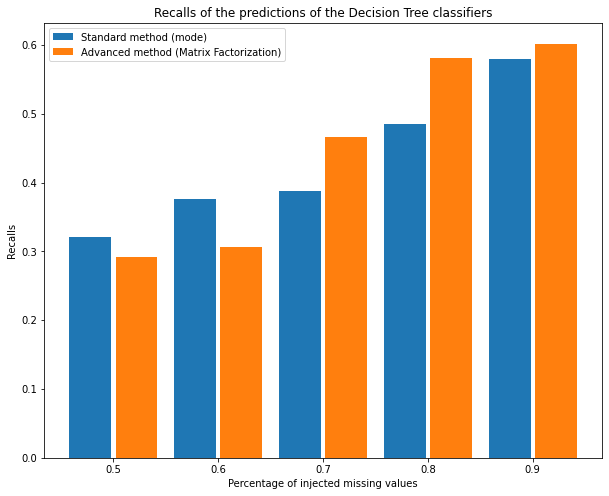

In [82]:
#decision tree

values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(dt_standard_imputation[i][3])
    values_advanced.append(dt_advanced_imputation[i][3])

plot_results_bar(values_standard, values_advanced, 
                "Recalls of the predictions of the Decision Tree classifiers", "Recalls")

[0.2938673341677096, 0.32465060492282016, 0.34524405506883604, 0.44310298587520114, 0.47159619166815664]
[0.3074989570296204, 0.3165780141843971, 0.48328043983550867, 0.45004916860361166, 0.4912956672030514]


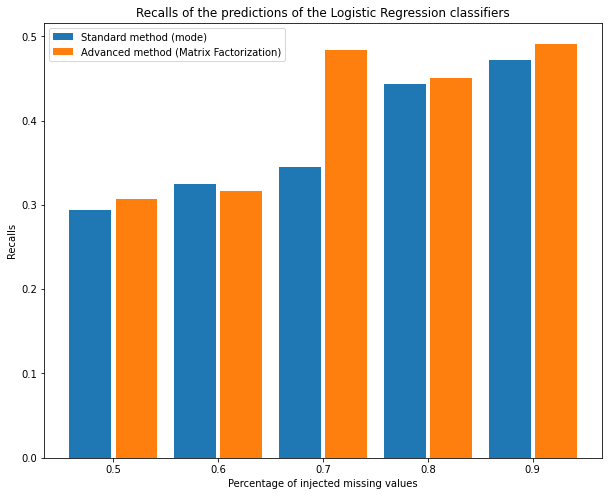

In [83]:
#logistic regression

values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(lr_standard_imputation[i][3])
    values_advanced.append(lr_advanced_imputation[i][3])

plot_results_bar(values_standard, values_advanced, 
                "Recalls of the predictions of the Logistic Regression classifiers", "Recalls")

### Machine Learning algorithms F1 scores

[0.3318419747284879, 0.3795162516700207, 0.402606582725867, 0.510171559942727, 0.592599116426096]
[0.2920884889388826, 0.29997267555953006, 0.48189251950056505, 0.5923284993632585, 0.62182872452582]


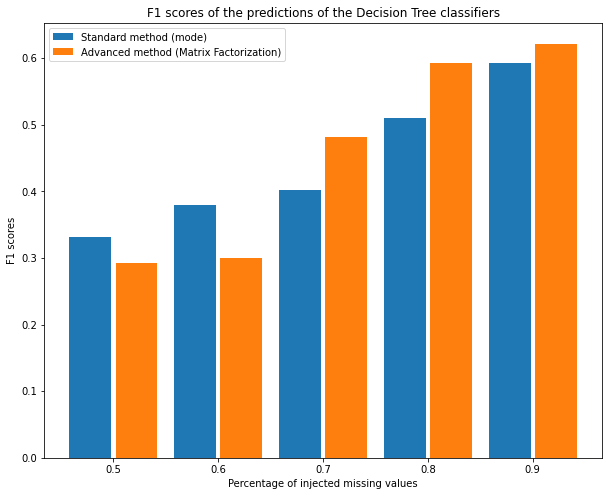

In [84]:
#decision tree

values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(dt_standard_imputation[i][4])
    values_advanced.append(dt_advanced_imputation[i][4])

plot_results_bar(values_standard, values_advanced, 
                "F1 scores of the predictions of the Decision Tree classifiers", "F1 scores")

[0.2820275889380239, 0.3333219820065254, 0.33880308880308874, 0.4605126947804293, 0.5127384302689181]
[0.30721343873517787, 0.3159910806255267, 0.5165933333821409, 0.4663491962866698, 0.5363054561095926]


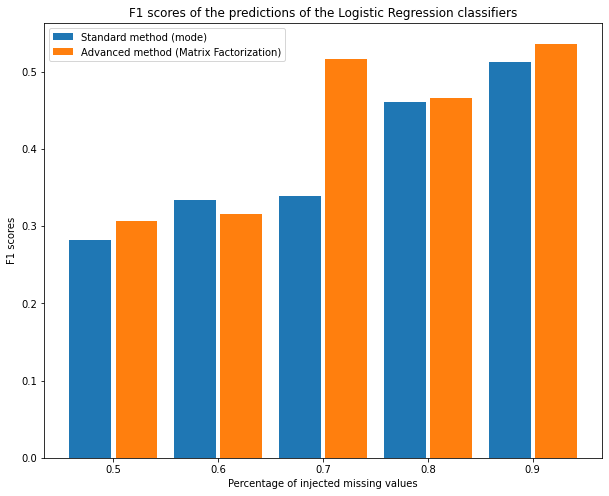

In [85]:
#logistic regression

values_standard = []
values_advanced = []

for i in range(len(nan_percentages)):
    values_standard.append(lr_standard_imputation[i][4])
    values_advanced.append(lr_advanced_imputation[i][4])

plot_results_bar(values_standard, values_advanced, 
                "F1 scores of the predictions of the Logistic Regression classifiers", "F1 scores")

### Machine Learning algorithms confusion matrices

In [86]:
def plot_confusion_matrices(cm_standard, cm_advanced, algorithm):
    "Function that plots the confusion matrices of the predictions of a classifier specified by the string algorithm"

    fig, axes = plt.subplots(2, len(nan_percentages), figsize=(25, 12))
    fig.suptitle("Confusion matrices of the " + algorithm + " classifiers" + 
                "\nFirst row for the datasets imputed with mode, second row for the datasets imputed with MF")

    labels = ["unacc", "acc", "good", "vgood"]

    for i in range(len(nan_percentages)):
        sns.heatmap(ax=axes[0,i], data=(cm_standard[i]).T, xticklabels=labels, yticklabels=labels, annot=True, linewidth=.5, fmt="d")
        axes[0,i].set_title("Injected null values ratio: " + nan_percentages[i])
        axes[0,i].set_xlabel("True labels")
        axes[0,i].set_ylabel("Predicted labels")

        sns.heatmap(ax=axes[1,i], data=(cm_advanced[i]).T, xticklabels=labels, yticklabels=labels, annot=True, linewidth=.5, fmt="d")
        axes[1,i].set_title("Injected null values ratio: " + nan_percentages[i])
        axes[1,i].set_xlabel("True labels")
        axes[1,i].set_ylabel("Predicted labels")

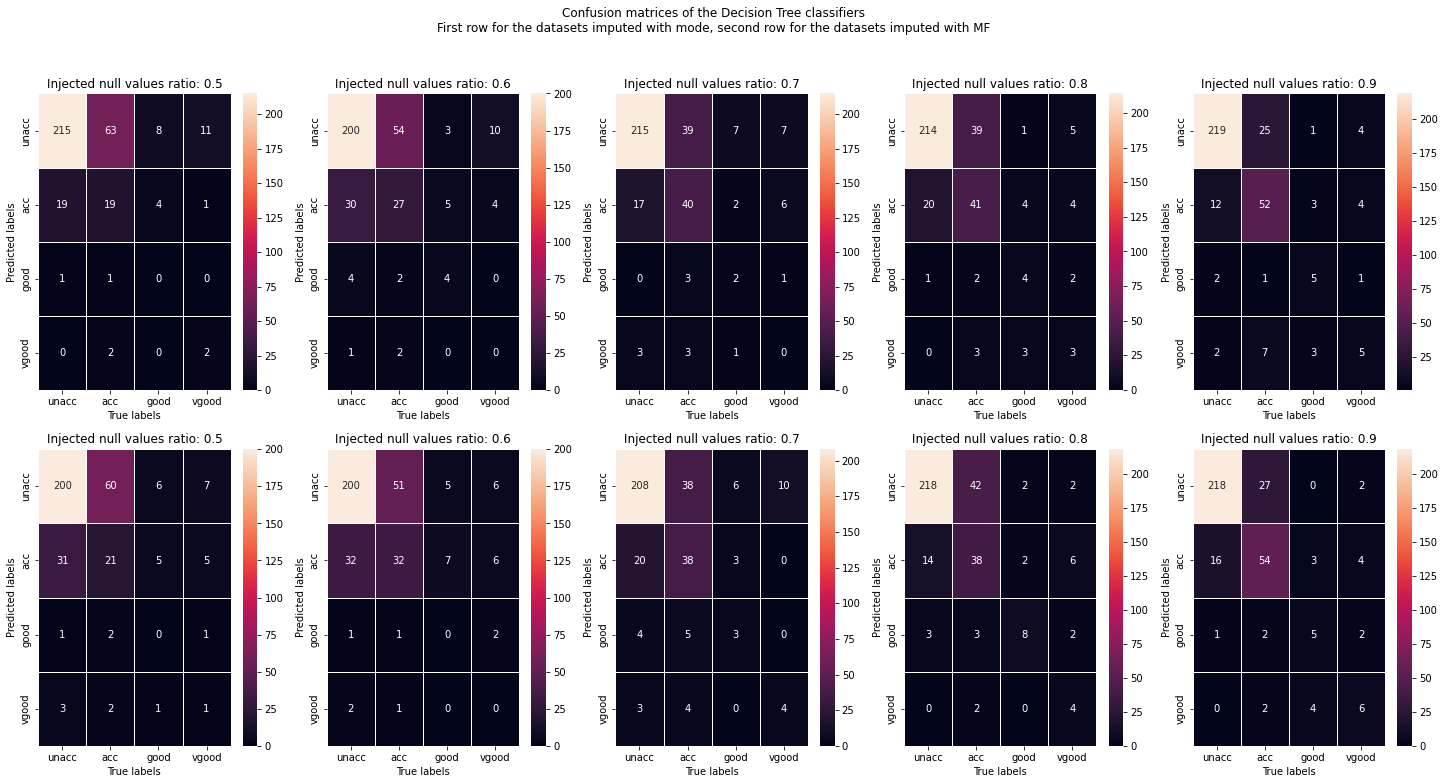

In [87]:
#decision tree
cm_standard = []
cm_advanced = []

for i in range(len(nan_percentages)):
    cm_standard.append(dt_standard_imputation[i][0])
    cm_advanced.append(dt_advanced_imputation[i][0])

plot_confusion_matrices(cm_standard, cm_advanced, "Decision Tree")

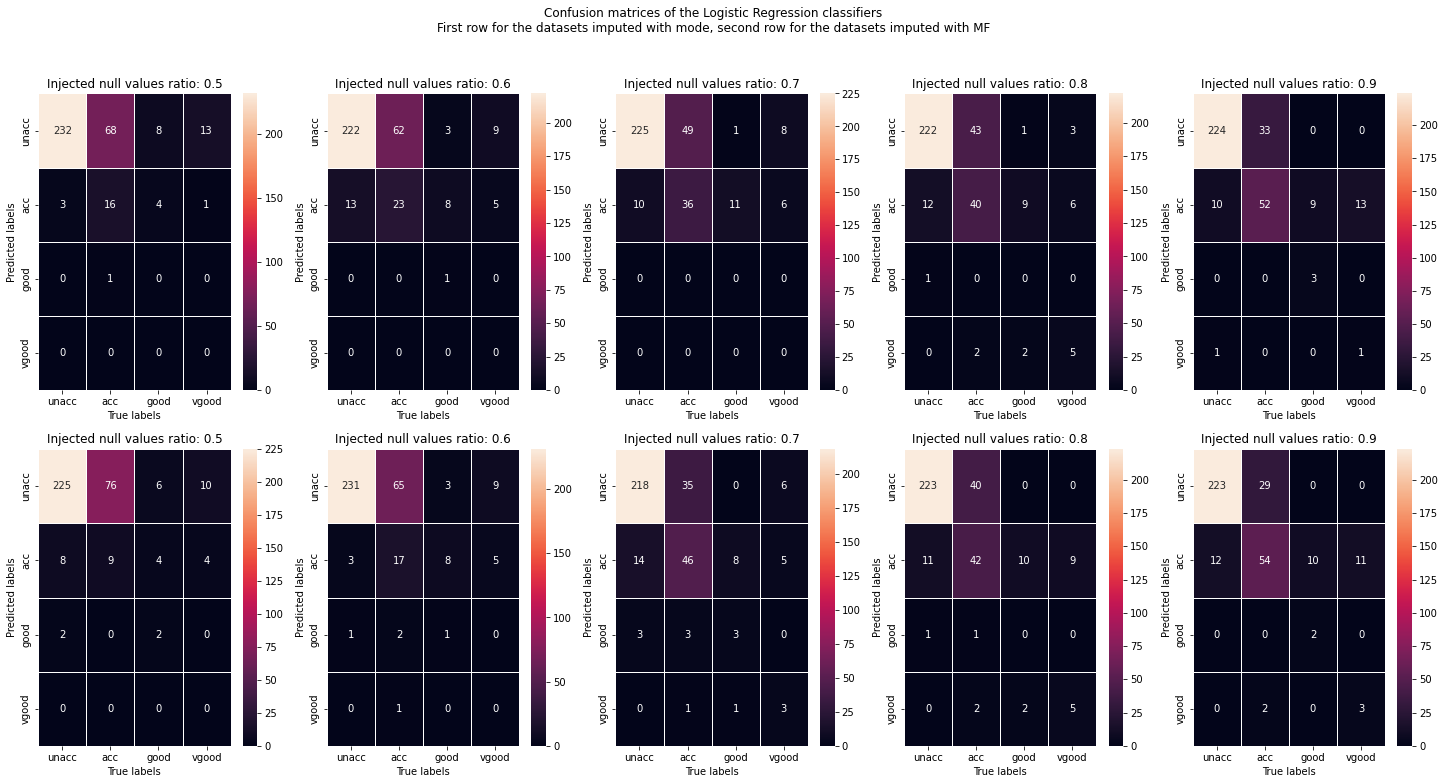

In [88]:
#logistic regression
cm_standard = []
cm_advanced = []

for i in range(len(nan_percentages)):
    cm_standard.append(lr_standard_imputation[i][0])
    cm_advanced.append(lr_advanced_imputation[i][0])

plot_confusion_matrices(cm_standard, cm_advanced, "Logistic Regression")